In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [3]:
# Checkpoint
consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

list(consolidated_df.columns)

['Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'CRSDepTime',
 'CRSArrTime',
 'CRSElapsedTime',
 'Distance',
 'DistanceGroup',
 'YEAR MFR',
 'HORSEPOWER',
 'THRUST',
 'NO-SEATS',
 'Origin_LATITUDE',
 'Origin_LONGITUDE',
 'Dest_LATITUDE',
 'Dest_LONGITUDE',
 'Reporting_Airline',
 'Tail_Number',
 'Origin',
 'Dest',
 'TYPE REGISTRANT',
 'NAME',
 'CERTIFICATION',
 'TYPE ENGINE',
 'STATUS CODE',
 'MFR',
 'MODEL',
 'TYPE',
 'MFR_aircraft',
 'MODEL_aircraft',
 'TYPE-ENG',
 'BUILD-CERT-IND',
 'Origin_DISPLAY_AIRPORT_NAME',
 'Origin_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'Dest_DISPLAY_AIRPORT_NAME',
 'Dest_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'DepDel15',
 'ArrDel15',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [4]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    # "DistanceGroup",
    "YEAR MFR",
    # "HORSEPOWER",
    # "THRUST",
    # "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    # "Tail_Number",
    "Origin",
    "Dest",
    # "TYPE REGISTRANT",
    # "NAME",
    # "CERTIFICATION",
    # "TYPE ENGINE",
    # "STATUS CODE",
    # "MFR",
    # "MODEL",
    # "TYPE",
    # "MFR_aircraft",
    # "MODEL_aircraft",
    # "TYPE-ENG",
    #
    "DepDel15",
    "ArrDel15",
    # "CarrierDelay",
    # "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]

In [5]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "YEAR MFR",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Origin",
    "Dest",
    # convert these to "delayed"
    "DepDel15",
    "ArrDel15",
]


delay_df = consolidated_df[num_cols + cat_cols].copy()

# If the flight is delayed on departure or arrival, consider it delayed overall
delay_df["delayed"] = (delay_df["DepDel15"].eq(1)) | (delay_df["ArrDel15"].eq(1))

delay_df = delay_df.drop(columns=["DepDel15", "ArrDel15"], axis=1)

delay_df = delay_df.dropna(how=("any"), axis="index")

# Redefine this variable for the rest of the notebook
cat_cols = ["Reporting_Airline", "Origin", "Dest"]

delay_df.value_counts("delayed")
# False    7074065
# True       53021

delayed
False    5372372
True     1588465
Name: count, dtype: int64

In [14]:
from sklearn.preprocessing import OrdinalEncoder


correlation_df = delay_df.copy()

ordinal_encoder = OrdinalEncoder()

for col in cat_cols:
    correlation_df[col] = ordinal_encoder.fit_transform(
        correlation_df[col].values.reshape(-1, 1)
    )

correlation_matrix = correlation_df.corr()

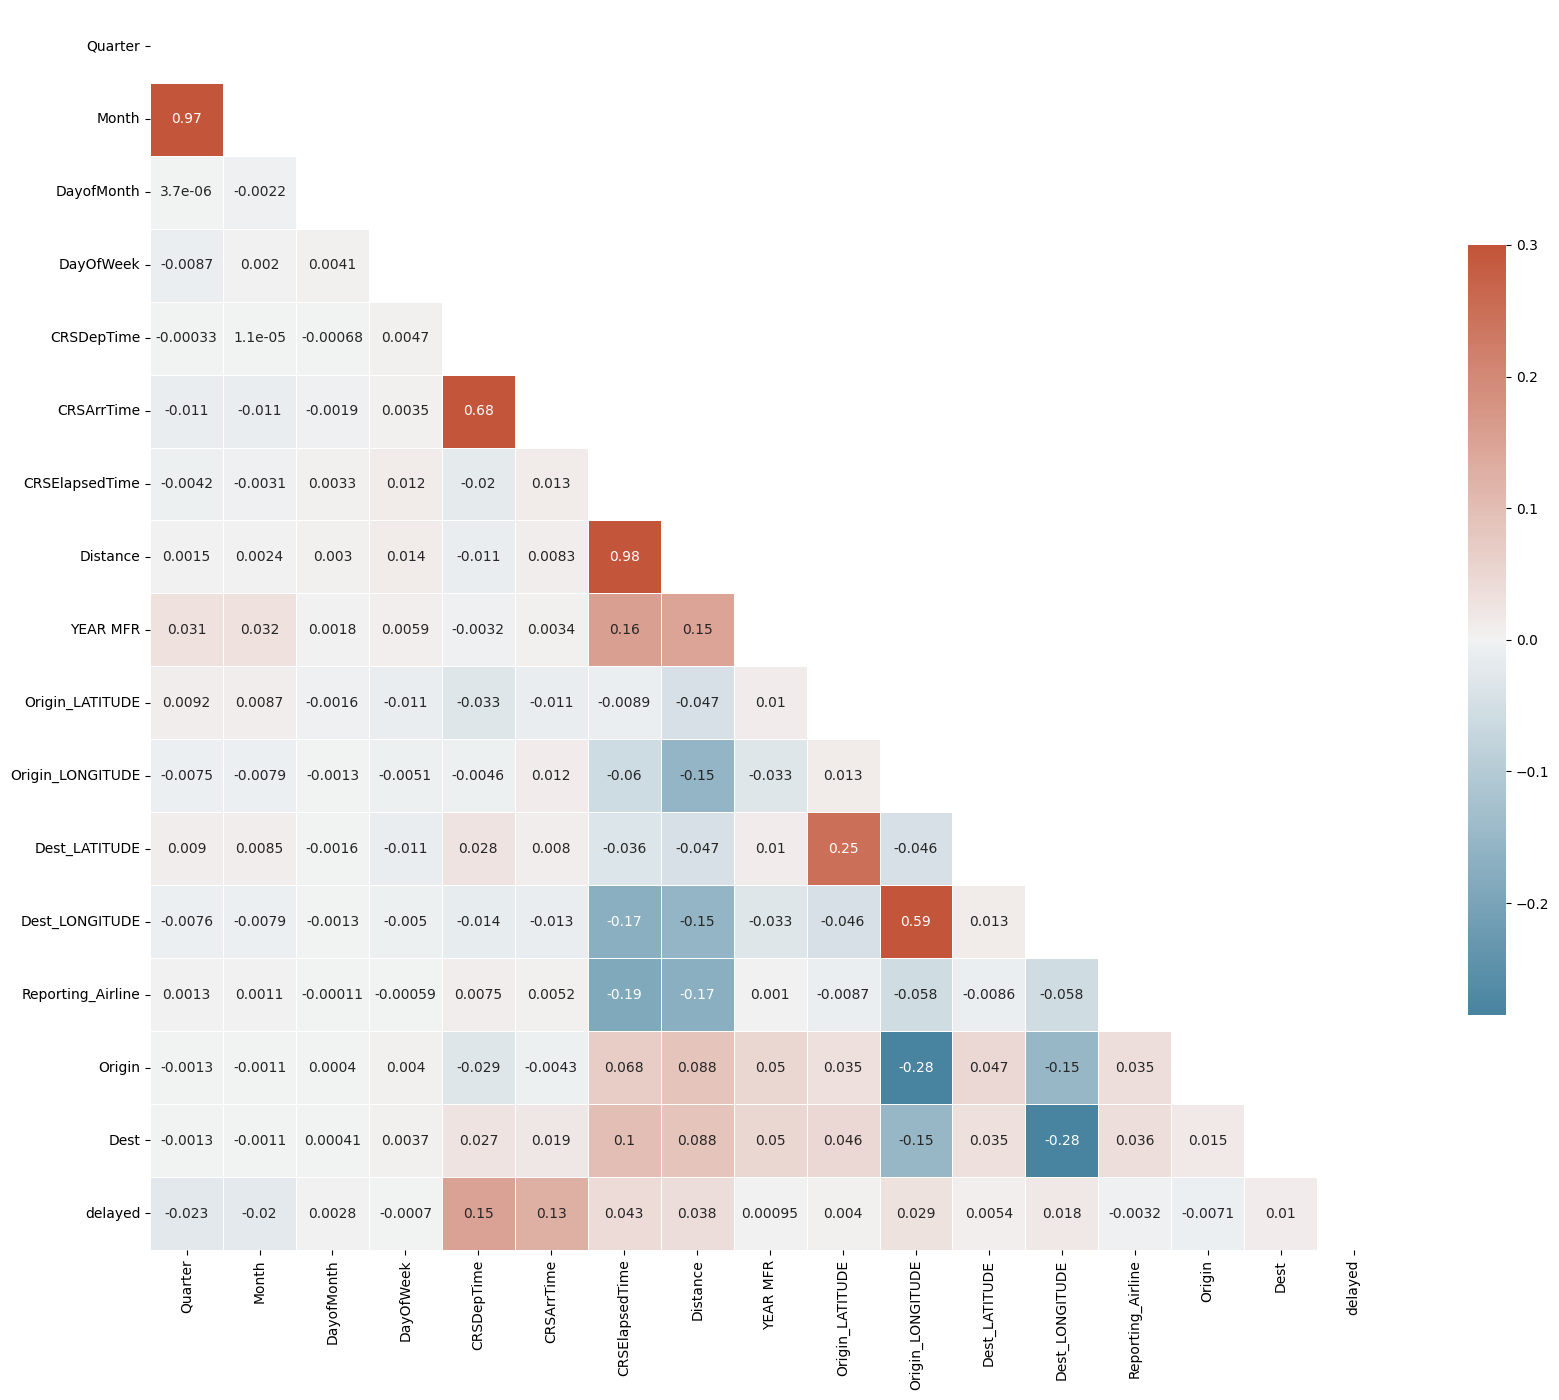

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


start_time = time.time()


X = delay_df.drop("delayed", axis=1)
y = delay_df["delayed"]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        # ("cat", OneHotEncoder(), cat_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 79.1760 seconds


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

In [18]:
from sklearn.linear_model import Ridge


# Fit Ridge model with an arbitrary regularization parameter alpha
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Get feature names after one-hot encoding for categorical variables
feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

# Get the coefficients
coefficients = ridge.coef_

# Pair feature names with their corresponding coefficients
feature_importance = list(zip(feature_names, coefficients))

# Sort features by the absolute value of their coefficients
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)


sorted_features

[('CRSElapsedTime', 0.09671474020466012),
 ('Distance', -0.07572646020612044),
 ('CRSDepTime', 0.05273116644074482),
 ('Quarter', -0.02234463009075502),
 ('CRSArrTime', 0.017288543725419523),
 ('Dest_LONGITUDE', 0.01622013836972163),
 ('Month', 0.014163718346596627),
 ('YEAR MFR', -0.0031467576565681415),
 ('Origin_LONGITUDE', -0.002754066960276477),
 ('Origin_LATITUDE', 0.0017217494302476496),
 ('DayofMonth', 0.0011499758733908353),
 ('Reporting_Airline', 0.0007714163854062952),
 ('DayOfWeek', -0.0006866011129973679),
 ('Dest_LATITUDE', -0.00028300987612564515),
 ('Dest', 3.765811112793631e-05),
 ('Origin', 2.8146603397284286e-06)]

In [19]:
from sklearn.linear_model import Lasso


# Fit Lasso model with an arbitrary regularization parameter alpha
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Get feature names after "Ordinal" encoding for categorical variables
feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

# Find where the lasso coefficients are not 0
important_features = np.nonzero(lasso.coef_)[0]
important_feature_names = [feature_names[i] for i in important_features]


important_feature_names  # :(

['Origin', 'Dest']

In [20]:
from imblearn.over_sampling import SMOTE

start_time = time.time()

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 2607.6573 seconds


In [21]:
with open(f"{SCRATCH_DIR}/15_delays_2019_X_res_auto.pkl", "wb") as f:
    pickle.dump(X_res, f)

with open(f"{SCRATCH_DIR}/15_delays_2019_y_res_auto.pkl", "wb") as f:
    pickle.dump(y_res, f)

In [8]:
with open(f"{SCRATCH_DIR}/15_delays_2019_X_res_auto.pkl", "rb") as f:
    X_res = pickle.load(f)

with open(f"{SCRATCH_DIR}/15_delays_2019_y_res_auto.pkl", "rb") as f:
    y_res = pickle.load(f)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    print(">>>", sum(fit_y_train == 0) / sum(fit_y_train == 1))

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        # Handle imbalance
        scale_pos_weight=sum(fit_y_train == 0) / sum(fit_y_train == 1),
    )

    #     ftwo_scorer = make_scorer(fbeta_score, beta=2)
    scorer = make_scorer(recall_score)

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid={
            "learning_rate": [0.1],  # , 0.2, 0.3],
            "max_depth": [10],  # [5, 7, 10],
            "n_estimators": [150],  # , 250, 500],
            "subsample": [0.7],  # [0.6, 0.7, 0.8],
            "colsample_bytree": [0.7],  # [0.6, 0.7, 0.8],
        },
        scoring=scorer, # "average_precision",  # AUC-PR
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search

In [37]:
start_time = time.time()

model = fit_grid_search_xg_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

>>> 1.0


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

Elapsed time: 471.0890 seconds


In [38]:
# Checkpoint on the xgboost model

with open(f"{SCRATCH_DIR}/15_all_delays_xgboost_smote_recall.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/15_all_delays_xgboost_smote.pkl", "rb") as f:
#     model = pickle.load(f)

In [9]:
# Trying a grid search to improve recall

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    start_time = time.time()

    #     ftwo_scorer = make_scorer(fbeta_score, beta=2)

    #     scorer = make_scorer(recall_score)

    model = GridSearchCV(
        LogisticRegression(solver="saga", max_iter=1000),
        param_grid={},
        scoring="average_precision",
        cv=5,
        n_jobs=-1,
    )

    model.fit(fit_X_train, fit_y_train)

    end_time = time.time()

    print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

    return model

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def fit_grid_search_random_forest(fit_X_train, fit_y_train):
    start_time = time.time()

    rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid={
            "n_estimators": [100],  # [50, 100, 150],
            "max_depth": [None],  # , 10, 20, 30],
            "min_samples_split": [2],  #  5, 10],
            "min_samples_leaf": [1],  #  2, 4],
        },
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(fit_X_train, fit_y_train)

    end_time = time.time()

    print(f"Finished Fitting Model: {(end_time - start_time):.4f} seconds")

    return grid_search

In [140]:
start_time = time.time()

model = fit_grid_search_random_forest(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Finished Fitting Model: 6496.3723 seconds
Elapsed time: 6496.5838 seconds


In [141]:
# Checkpoint on the random forest model

with open(f"{SCRATCH_DIR}/14_weather_delays_random_forest.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_random_forest.pkl", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def fit_grid_search_svm(fit_X_train, fit_y_train):
    svm_param_grid = {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["auto", "scale"],
    }

    svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)

    svm_grid_search.fit(fit_X_train, fit_y_train)

    print("Best SVM parameters: ", svm_grid_search.best_params_)
    print("Best SVM score: ", svm_grid_search.best_score_)

    return svm_grid_search

In [ ]:
start_time = time.time()

model = fit_grid_search_svm(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint on the SVM model

with open(f"{SCRATCH_DIR}/14_weather_delays_svm.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_svm.pkl", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    gb_param_grid = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "max_depth": [1, 3, 5],
    }

    gb_grid_search = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=5)

    gb_grid_search.fit(fit_X_train, fit_y_train)

    print("Best Gradient Boosting parameters: ", gb_grid_search.best_params_)
    print("Best Gradient Boosting score: ", gb_grid_search.best_score_)

    return gb_grid_search

In [ ]:
start_time = time.time()

model = fit_grid_search_gradient_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint on the Gradient Boost model

with open(f"{SCRATCH_DIR}/14_weather_delays_gradient_boost.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_gradient_boost.pkl", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [39]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

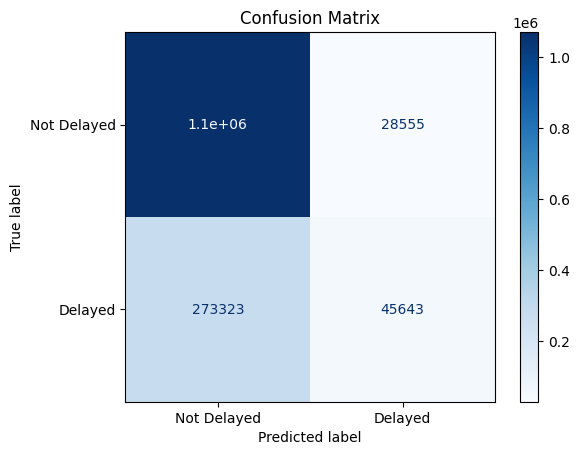

In [40]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [41]:
cm

# XGBoost
# array([[1225409,  182135],
#        [   2756,    7707]])

# Random Forest
# array([[1407521,      23],
#        [  10375,      88]])

array([[1070486,   28555],
       [ 273323,   45643]])

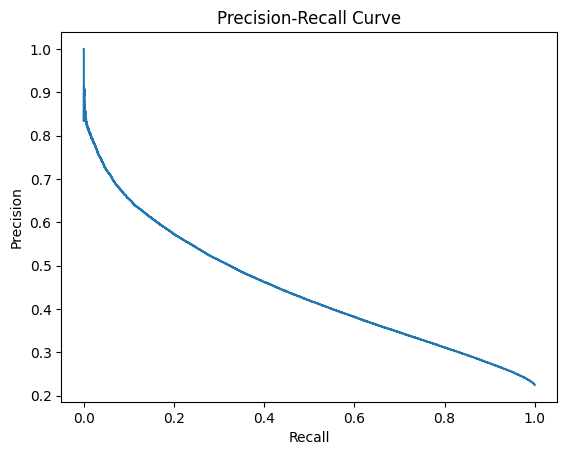

In [42]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [43]:
from sklearn.metrics import roc_auc_score


y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# random forest
# 0.5041971245888275

ra_score

0.558557507064853

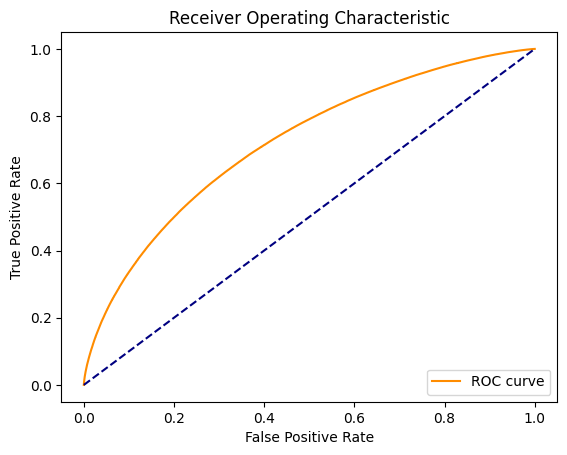

In [44]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [45]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


metrics_scores = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

alt.Chart(df_metrics).mark_bar().encode(
    y="Metric:N", x="Score:Q", color="Metric:N", text=alt.Text("Score:Q", format=".2f")
).properties(title="Evaluation Metrics", width=600, height=300).configure_axis(
    labelFontSize=12, titleFontSize=14
)

alt.Chart(...)